<h3>Stool microbiome and obesity </h3>

The microbiome refers to all the microorganisms that live on or within the human body. Microorganisms can be found thriving in many sites of the body, including the skin, uterus, mouth and gastrointestinal tract. In fact it is estimated that there are more bacteria than cells in the human body, thus it is not surprising that studies have shown the microbiome has a significant impact on physical and even mental health. We have so much interdependence with the bacteria living on or in us, some studies have shown that the species composition of the gut microbiome is associated with many diseases, from cancer to metabolic syndrome. There is crosstalk between our body and the microbiome, our lifestyles and habits can alter the communities of our microbiome; their diversity and composition in turn affect our health.

Although I'm currently working as a forensic scientist, my graduate research was on microbiology so I am quite interested in the correlation between the  composition of an individual's stool microbiome and their physical status, especially any genus/species of bacteria that are important for the prediction of obesity. This would be a good opportunity to practice my analytics skills too, since I don't get to use them in my day to day work.



<sub>The dataset I'm using is a human metagenomics dataset from Kaggle which can be found [here](https://www.kaggle.com/antaresnyc/human-metagenomics?select=abundance_stoolsubset.csv). Credits for the data go to the original authors of the study and Kaggle user Alexey Kotlik who uploaded it. </sub>

In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
### import packages ###

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
### import raw data

data = pd.read_csv('metagenomics/abundance_stoolsubset.csv', dtype='str')
cols = data.columns

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
# Let's take a look at the raw data

print('sample dimensions are {} rows by {} columns'.format(data.shape[0], data.shape[1]))
print('')
data.head(2)

sample dimensions are 1989 rows by 2339 columns



,dataset_name,sampleID,subjectID,bodysite,disease,age,gender,country,sequencing_technology,pubmedid,...,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Enterococcaceae|g__Enterococcus|s__Enterococcus_gilvus|t__Enterococcus_gilvus_unclassified,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis,k__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus_otakiensis|t__GCF_000415925,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Peptococcaceae|g__Desulfotomaculum|s__Desulfotomaculum_ruminis|t__GCF_000215085,k__Bacteria|p__Firmicutes|c__Clostridia|o__Clostridiales|f__Ruminococcaceae|g__Faecalibacterium|s__Faecalibacterium_prausnitzii|t__GCF_000209855,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1,k__Bacteria|p__Firmicutes|c__Negativicutes|o__Selenomonadales|f__Veillonellaceae|g__Megasphaera|s__Megasphaera_sp_BV3C16_1|t__GCF_000478965
0,Candela_Africa,H10,h10,stool,n,40,female,tanzania,Illumina,25981789,...,0,0,0,0,0,0,0,0,0,0
1,Candela_Africa,H11,h11,stool,n,29,female,tanzania,Illumina,25981789,...,0,0,0,0,0,0,0,0,0,0


This dataset is pretty high dimensional with 2339 columns, but most of the columns are not really relevant to what I'm doing. Gender, age and country is available too, which gives me an idea to try something similar to this but see if I can differentiate gender or location based on microbiome. But that'll be something for the future.

Since I'm interested in obesity, I'll filter for that data with indicators of obesity and normal individuals. I got my BMI categories here from [NIH](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmicalc.htm), which is:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-c3ow{border-color:inherit;text-align:center;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-c3ow">Underweight</th>
    <th class="tg-c3ow">&lt;18.5</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-c3ow">Normal</td>
    <td class="tg-c3ow">18.5-24.9</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Overweight</td>
    <td class="tg-c3ow">25-29.9</td>
  </tr>
  <tr>
    <td class="tg-c3ow">Obesity</td>
    <td class="tg-c3ow">&gt;=30</td>
  </tr>
</tbody>
</table>

In the cell below, I drop the columns which I won't be using, except for some that identifies where the sample is from. I won't be using data from individuals with other diseases, only those who are healthy or obese, so as to not add any confounding variables or other complications in the modeling.

In [3]:
### preprocess data ###

# filter for categories of interest

processed = data[data['disease'].isin(['obesity', 'obese', 'overweight','leaness', 'n'])].copy()

# drop columns that are not needed
to_drop = list(cols[2:4]) + list(cols[8:20]) + list(cols[21:211])
processed.drop(columns = to_drop, inplace = True)

# remove samples without bmi, convert bmi and abundance to float and filter for regular weight and obese
processed = processed[~processed['bmi'].isin(['na', 'nd'])]

processed['bmi'] = pd.to_numeric(processed['bmi'], downcast ='float')

processed.iloc[:, 7:] = processed.iloc[:, 7:].apply(pd.to_numeric)


# create labels for classification

bmi = [(processed['bmi'] >= 18.5) & (processed['bmi'] < 25), (processed['bmi'] >= 25) & (processed['bmi'] < 30), processed['bmi'] >= 30 ]

categories = ['1','2','3']

classes = np.select(bmi, categories, default = '0')

np.unique(classes, return_counts=True)

(array(['0', '1', '2', '3'], dtype='<U1'),
 array([ 35, 444, 177, 309], dtype=int64))

There are too little observations for underweight data, which will affect the modeling accuracy. Since I'm curious about the microbiome composition of normal and obese individuals (classes 1 and 3), I'll just drop the classes I'm not interested in and proceed rather than getting bogged down in dealing with the data imbalance.

In [4]:
bmi = [(processed['bmi'] >= 18.5) & (processed['bmi'] < 25), processed['bmi'] >= 30 ]

categories = ['0','1']

processed['bmi_category'] = np.select(bmi, categories, default = '2')

I also noticed some "redundancy" in the relative abdundance data which should be removed after the initial data cleaning:

The relative abundance for every species is recorded multiple times in the data, as an example, let's look at the data for Archaea bacteria for the $6^{th}$ observation

In [5]:
processed.iloc[5, 7:20]

k__Archaea                                                                                                                                                                                      0.4308
k__Archaea|p__Euryarchaeota                                                                                                                                                                     0.4308
k__Archaea|p__Euryarchaeota|c__Methanobacteria                                                                                                                                                  0.4308
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales                                                                                                                            0.4308
k__Archaea|p__Euryarchaeota|c__Methanobacteria|o__Methanobacteriales|f__Methanobacteriaceae                                                                                                     0.4308
k__Ar

The first letter of the name of columns stands for taxonomic rank. For example, in the output above, the first row (col 7), "k__Archaea", is for the kingdom of [Archaea](https://en.wikipedia.org/wiki/Archaea) and summ abundance of all bacteria from this kingdom is 0.4308. Row 2, "k__Archaea|p__Euryarchaeota" is referring to the phylum of Euryarchaeota within the Archaea kingdom. (See [Bacteria Taxonomy](https://en.wikipedia.org/wiki/Bacterial_taxonomy)). Since I'm interested at the species, I'll be removing columns of other taxonomic ranks. Notice that for Methanobrevibacter smithii, there is an even lower rank which starts with "t" which refers to type, however not every species in the dataset has a type, I'll stop at the species level.

We can see that for this data point, only 2 species were detected, *M.smithii* and a unclassified methanobrevibacter, at 0.3816 and 0.04919 abundance respectively. And both values add up to 0.4308, which confirms that I'm not reading the data wrong.

I'll use regex to find column names that contain species level abundance and filter the other columns. And since I'm already filtering at the species level anyways, I'm quite curious to study genus level data as well, so I'll filter for those too. But different species of bacteria within the same genus can have different biochemistry and life cycles, so it is likely that genus will not be as good a predictor.

In [6]:
# get names of all columns that contain abundance data
bacteria = list(processed.columns)[7:-1]

# use regex to select exclusively for columns that contain species level abundance

# filters for species level
s = re.compile(r'(\|s__\w+$)')

# filter for genus level
g = re.compile(r'\|g__\w+$')


not_species = [i for i in bacteria if not s.search(i)]
not_genus = [j for j in bacteria if not g.search(j)]

# drop columns that are not needed
species_data = processed[processed['bmi_category'] != '2'].drop(columns = not_species)

genus_data = processed[processed['bmi_category'] != '2'].drop(columns = not_genus)

In [71]:
print('New dimensions of the dataset:')
print()
print('Species level dataset: {} rows by {} cols'.format(species_data.shape[0], species_data.shape[1]))
print()
print('Genus level dataset: {} rows by {} cols'.format(genus_data.shape[0], genus_data.shape[1]))


New dimensions of the dataset:

Species level dataset: 753 rows by 834 cols

Genus level dataset: 753 rows by 300 cols


Next is to shorten the feature names into something more readable:

In [7]:
# rename feature names to shorter ones for species

s = re.compile(r's__(\w+)')

short = []

for i in list(species_data)[7:-1]:
    short.append(s.search(i).group(1).replace("_", " "))
    
new = dict(zip(species_data, list(species_data)[:7] + short))

species_data.rename(columns = new, inplace=True)

# same thing for genus

g = re.compile(r'g__(\w+)')

short = []

for i in list(genus_data)[7:-1]:
    short.append(g.search(i).group(1).replace("_", " "))
    
new = dict(zip(genus_data, list(genus_data)[:7] + short))

genus_data.rename(columns = new, inplace=True)

Now to do a check on the data, first for missing values. Also, since this is a relative abundance dataset, the total values in each observation should add up to 100:

In [32]:
# quick and dirty missing value check

print('there are {} missing values in species and {} in genus.'.format(species_data.isna().sum().sum(), genus_data.isna().sum().sum()))

there are 0 missing values in species and 0 in genus.


In [33]:
# a list to collect index of observations that add up to 0 or more than 100
gt = []
lt = []
for i in range(len(species_data)):
    if (species_data.iloc[i, 7:-1].sum() > 100):
        gt.append(i)
    elif species_data.iloc[i, 7:-1].sum() <= 100:
        lt.append(i)

print('{} observations >100% and {} observations <100% to check'.format(len(gt), len(lt)))


138 observations >100% and 827 observations <100% to check


That's a lot of observations with issues, let's take a look at those that add up to less than 100 first.

In [34]:
for i in np.random.randint(0, 827, size=10):
    print('row {}, total abundance {}'.format(lt[i], species_data.iloc[lt[i], 7:-1].sum()))


row 245, total abundance 99.86757999999995
row 590, total abundance 99.99682999999997
row 68, total abundance 99.99678999999998
row 559, total abundance 99.86189000000006
row 520, total abundance 99.34902999999998
row 620, total abundance 99.99302999999999
row 438, total abundance 99.99999
row 247, total abundance 98.73499000000002
row 236, total abundance 99.99757999999999
row 771, total abundance 99.96080000000003


And those that add up to more than 100

In [35]:
for i in np.random.randint(0, 138, size=10):
    print('row {}, total abundance {}'.format(gt[i], species_data.iloc[gt[i], 7:-1].sum()))

row 434, total abundance 100.00002999999998
row 271, total abundance 100.00002000000002
row 117, total abundance 100.00002999999998
row 437, total abundance 100.00000000000001
row 86, total abundance 100.00000999999999
row 920, total abundance 100.00002000000002
row 460, total abundance 100.00001999999998
row 380, total abundance 100.00001999999999
row 501, total abundance 100.00000000000003
row 498, total abundance 100.00001999999998


It seems like the issue is due to floating point imprecision or rounding errors, it shouldn't affect the modeling then. Now to check the genus dataset.

In [36]:
# a list to collect index of observations that might be problematic
gt = []
lt = []
for i in range(len(genus_data)):
    if (genus_data.iloc[i, 7:-1].sum() > 100.01):
        gt.append(i)
    elif genus_data.iloc[i, 7:-1].sum() <= 99.01:
        lt.append(i)

print('{} observations >100% and {} observations <99% to check'.format(len(gt), len(lt)))



0 observations >100% and 0 observations <99% to check


Now that I'm satisfied with the state of the data, let's take a deeper look into the data.

First let's look at the correlation between the variables and the classes. In this case, I'm looking for correlation between dichotomous categorical variables, the 2 classes and continuous variables which are not normally distributed. (In case you were wondering, my earlier explorations into the data showed me the data is mostly sparse and not normally distributed.)

So in this case, I use the Mann-Whitney U test and calculate [rank-biserial correlation](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test#Rank-biserial_correlation) for the classes and each species of bacteria.


In [34]:
test1 = species_data.iloc[:, 217][species_data['bmi_category'] == '1']
test2 = species_data.iloc[:, 217][species_data['bmi_category'] == '0']

In [35]:
from scipy.stats import mannwhitneyu

mannwhitneyu(test1, test2)

MannwhitneyuResult(statistic=67197.0, pvalue=0.04148636244240522)

In [36]:
mannwhitneyu(test2, test1)

MannwhitneyuResult(statistic=69999.0, pvalue=0.04148636244240522)

In [298]:
def calculate_mann_whitney(df, column_name):
    '''Calculates mann_whitney U rank test rank-biserial correlation
    Assumes the data has only 2 classes, 1 and 0
    and the last column contains the classes'''

    calculate_mann_whitney

    # dictionary to collect data
    variables = {}

    for i in range(len(df.columns)-1):
        class0 = df[df.columns[i]][df[column_name] == '0']
        class1 = df[df.columns[i]][df[column_name] == '1']

        u = mannwhitneyu(class0, class1)[0]

        # the calculation of rank-biserial correlation changes depending on whether the test statistic, U, is the smaller one
        # since scipy always returns the test statistic of the first argument, rather than do 2 Mann-Whitney tests to get
        # both U1 and U2 to compare. I'll just stick to one calculation and absolute it to get the correlation regardless
        # of whether U is larger or smaller 
        variables[df.columns[i]]= np.absolute((2 * u)/(len(class0)*len(class1)) - 1)

    return pd.DataFrame.from_dict(variables, orient='index', columns = ['p-value'])

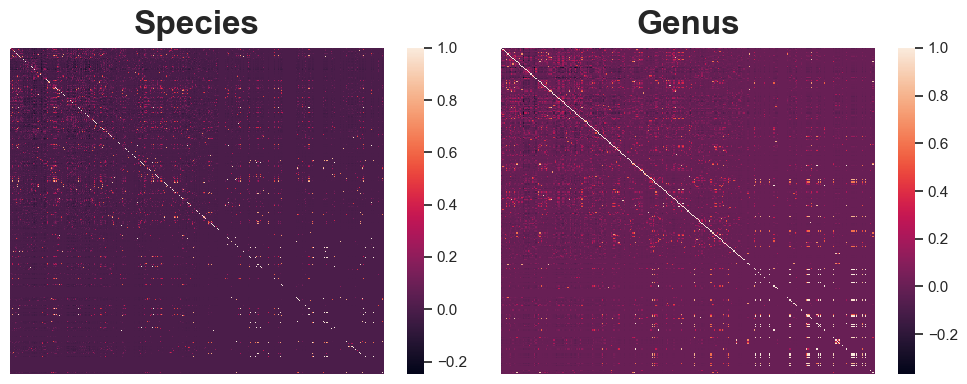

In [140]:
# calculate pearson correlation using pandas, generally, NA is returned if the values do not vary, and since this dataset is pretty sparse, there's probably going to be quite a lot of NAs, which I'll treat as having no correlation

species_corr = species_data.iloc[:, 6:-1].corr().fillna(0)

genus_corr = genus_data.iloc[:, 6:-1].corr().fillna(0)

sns.set_theme()
fig = plt.figure(figsize = (10,4), dpi=100)

ax1 = fig.add_subplot(1, 2, 1)
sns.heatmap(species_corr, xticklabels="", yticklabels="", ax=ax1)
ax1.set_title('Species', fontdict={'fontsize':24, 'fontweight':'demibold'}, pad=10)

ax2 = fig.add_subplot(1, 2, 2)
sns.heatmap(genus_corr, xticklabels="", yticklabels="", ax=ax2)
ax2.set_title('Genus', fontdict={'fontsize':24, 'fontweight':'demibold'}, pad=10)

plt.tight_layout()

Correlation between seems to be overall more positive in the genus data, but of course, correlation only tells us linear relationships and any more complex relationships won't be visible here. But it does seem promising and it may be possible that a linear model will be competitive with the more complex models.

Now to do the Mann-Whitney U test for both species and genus data. For this analysis, I'll collect the p-values and then plot the distributions of the 10 species/genera with the lowest p-values.

The dataset is quite sparse and widely spread, so I'll have to plot on a $log_{10}$ scale for visualisation. But the sparsity will then give me problems, what I'll do is add 0.00001 to the data before plotting them, so note that $10^{-5}$ on the x-axis simply means the abundance is 0%.

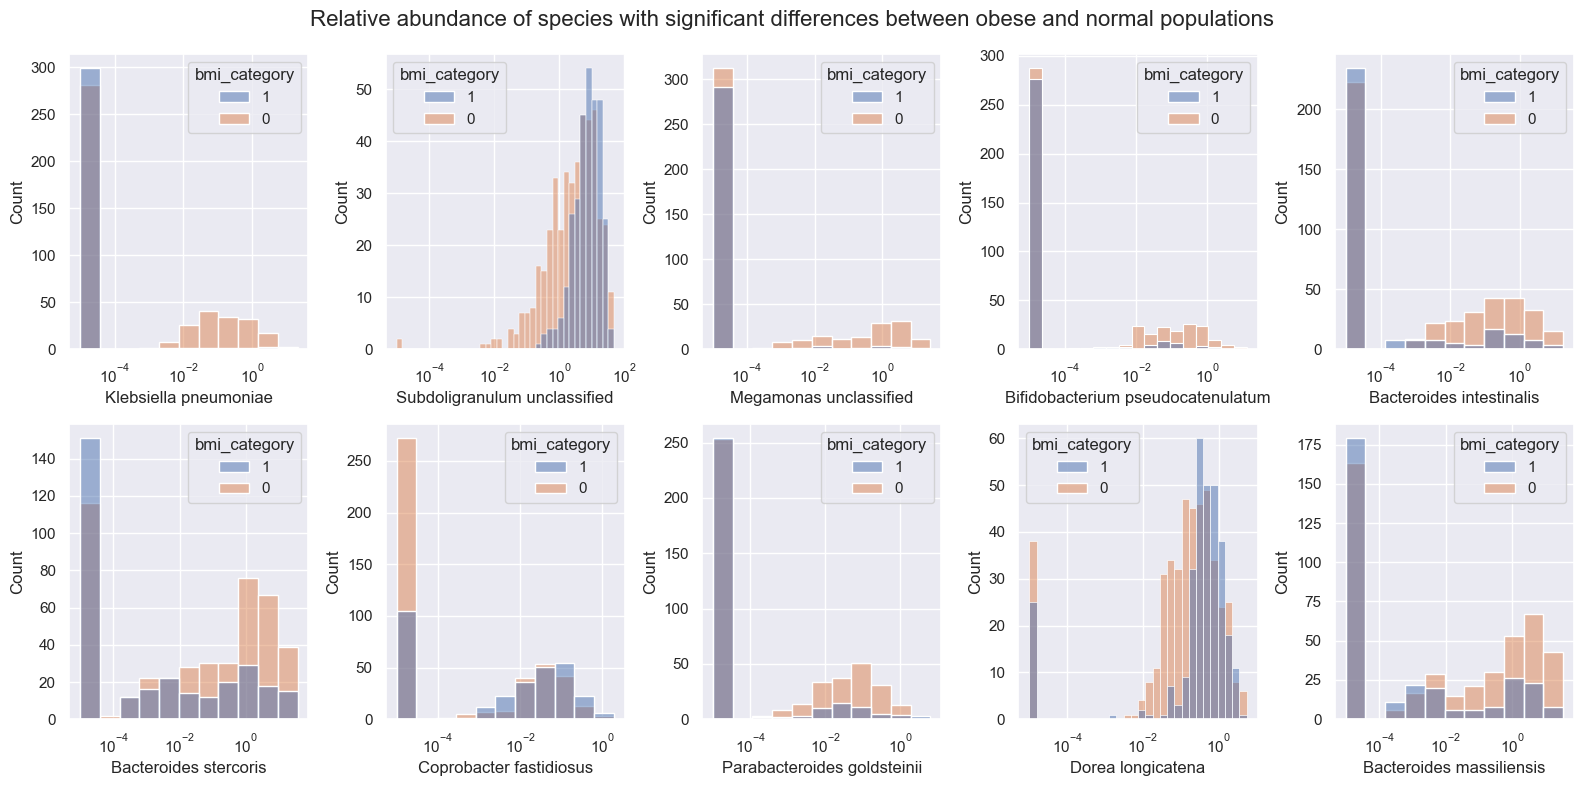

In [374]:
species_mann = calculate_mann_whitney(species_data.iloc[:, 7:], 'bmi_category')

fig = plt.figure(figsize=(16,8), dpi=100)

topSP = species_mann.sort_values(by='p-value', ascending=True).index.values[:10]

top_subset = pd.concat([(species_data[topSP] + 0.00001), species_data['bmi_category']], axis=1)

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    sns.histplot(data= top_subset, x = topSP[i], hue='bmi_category', log_scale=10)
    # plt.xlim(left = 0.001)

plt.suptitle('Relative abundance of species with significant differences between obese and normal populations', fontsize=16)
plt.tight_layout()

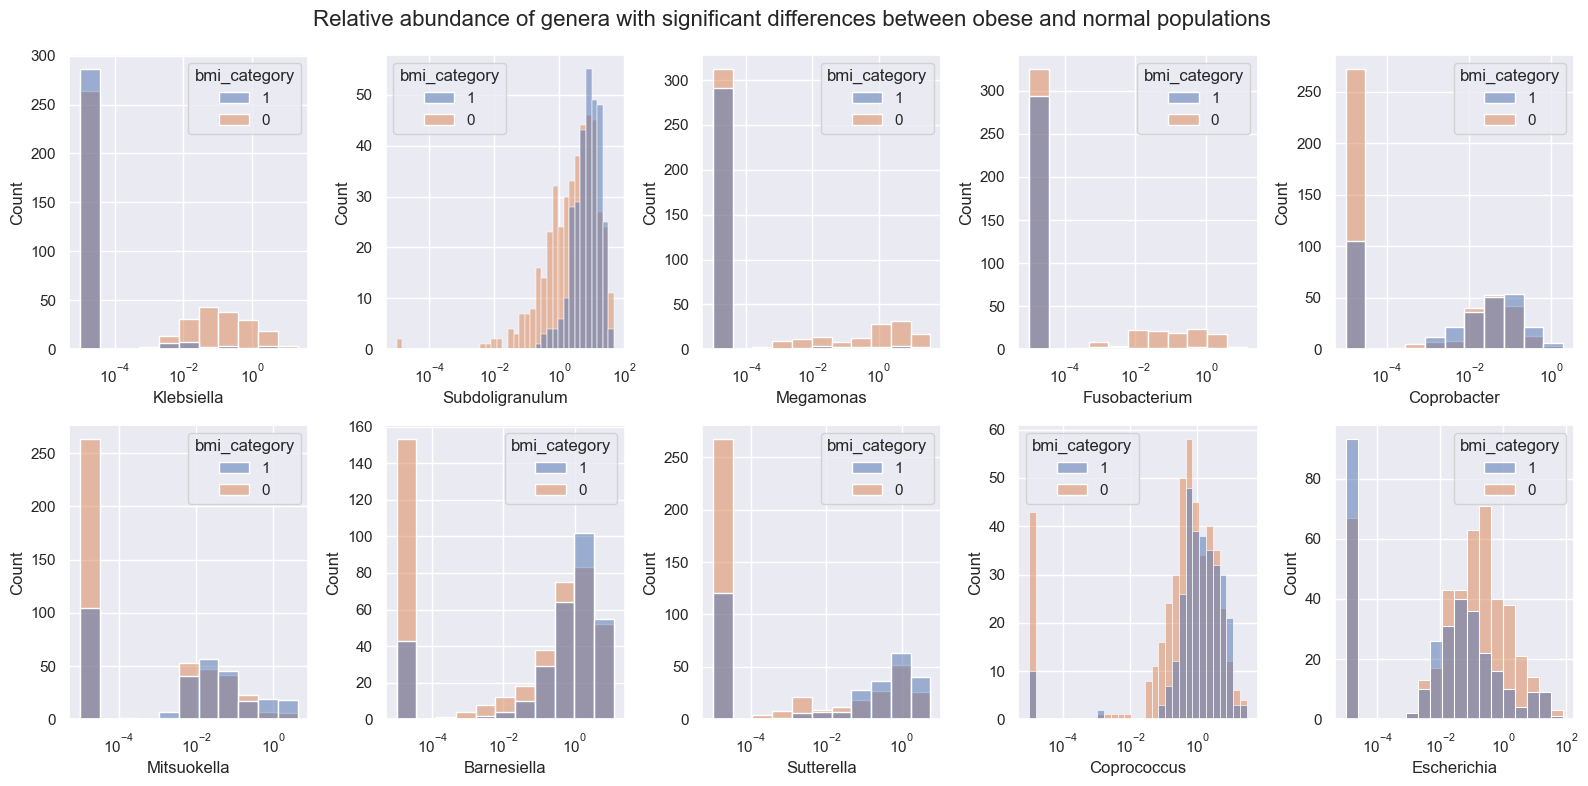

In [358]:
genus_mann = calculate_mann_whitney(genus_data.iloc[:, 7:], 'bmi_category')

fig = plt.figure(figsize=(16,8), dpi=100)

top = genus_mann.sort_values(by='p-value', ascending=True).index.values[:10]

top_subset = pd.concat([(genus_data[top] + 0.00001), genus_data['bmi_category']], axis=1)

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    sns.histplot(data= top_subset, x = top[i], hue='bmi_category', log_scale=10)

plt.suptitle('Relative abundance of genera with significant differences between obese and normal populations', fontsize=16)
plt.tight_layout()

I'm seeing the some of the same names in both genus and species, 2 scenarios are at play here:

1. A particular genus has a lot of species that are different in obese and normal observations
2. A particular genus has one dominant species which is different.

Both scenarios do occur, I did a rough check with the code below but I won't run it here so things look a bit tidier.

In [ ]:
# code to check whether scenario 1 or 2 is more frequent in the top species/genera
# It is quite interesting but I think its not that important to run.

# species_data[topSP].reindex(sorted(species_data[topSP].columns), axis=1).sum()

# genus_data[top].reindex(sorted(genus_data[top].columns), axis=1).sum()

Now let's scale the data before trying out a couple of models with the data:

1. Logistic regression
2. PLS-DA
3. SVM
4. Random Forest
5. Adaboost
6. Gradient Boost

While I'm curious about the importance of each species for separating obsese and normal microbiomes, the ultimate judge of the models will be classification accuracy on test data. I like to use log regression as a baseline model and if it performs well, I can use the coefficients to find species that differ greatly between normal and obese microbiomes. That said, I'm expecting the non-parametric or ensemble models to perform better, so I'm prepared to use permutation importance to find important microbes.

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

X = species_data.iloc[:, 7:species_data.shape[1]-1]
y = species_data.iloc[:, -1]

# split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 63)

# scale data based on training set
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)


In [100]:
# simple function to output the performance metrics of a model

def model_performance(y_true, y_pred):
    '''prints model metrics'''
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

    fig = plt.figure(dpi=100)

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=fig.gca(), display_labels=['normal','obese'])

    print(classification_report(y_true, y_pred))
    # print('balanced accuracy: {0:.4g}'.format(metrics.balance_accuracy_score(y_true, y_pred)))


# and another one to collate the scores
def model_comparison(models, names, x_test1, y_test, pls=None):
    '''Returns a dataframe of various classification metrics

    Parameters: 
    models: trained models
    names: names for models in dataframe
    x_test1: test data
    y_test: test classes
    pls: pls model, which is used to transform x_test before prediction
    
    '''

    assert len(models) == len(names), "number of models and names is not the same"

    model_scores = {}
   
    for i in range(len(names)):
        
        temp = {}
        
        if (names[i] == 'PLS-DA') :
            x_test = pls.transform(x_test1)
        else:
            x_test = x_test1

        temp['Balanced Accuracy'] = metrics.balanced_accuracy_score(y_test, models[i].predict(x_test))
        temp['ROC AUC'] = metrics.roc_auc_score(y_test, models[i].predict(x_test).astype(np.object))
        temp['Precision 1'] = metrics.precision_score(y_test, models[i].predict(x_test), pos_label = '1')
        temp['Precision 0'] = metrics.precision_score(y_test, models[i].predict(x_test), pos_label = '0')
        temp['Recall 1'] = metrics.recall_score(y_test, models[i].predict(x_test), pos_label = '1')
        temp['Recall 0'] = metrics.recall_score(y_test, models[i].predict(x_test), pos_label = '0')

        # create a dictionary for the current model
        model_scores[names[i]] = temp


        #tabulate metrics
    return pd.DataFrame.from_dict(model_scores, orient='index').round(3)


### Logistic regression ###

Since the species dataset has more variables than observations, some degree of regularisation will be necessary for a good fit.

              precision    recall  f1-score   support

           0       0.79      0.72      0.76        86
           1       0.67      0.75      0.71        65

    accuracy                           0.74       151
   macro avg       0.73      0.74      0.73       151
weighted avg       0.74      0.74      0.74       151



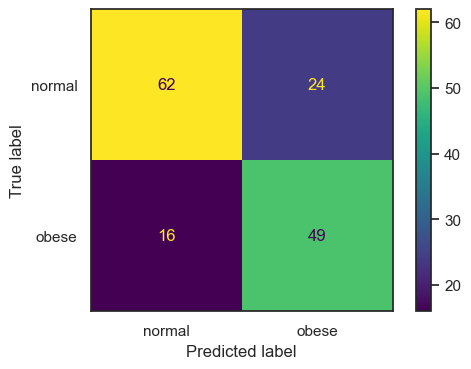

In [94]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, norm
sns.set_theme(style='white')

log_params = dict(C=uniform(loc=0.0, scale=20.0), penalty = ['l1', 'l2'])

# fit log regression
log_reg = LogisticRegression(random_state=78, max_iter=1000, solver='liblinear')

# randomized hyperparameter search
log_reg_CV = RandomizedSearchCV(log_reg, log_params, n_iter = 50, n_jobs=8, scoring = 'balanced_accuracy', refit=True).fit(x_train, y_train)

log_reg_CV.best_params_

model_performance(y_test,log_reg_CV.predict(x_test))

### Partial least squares discriminant analysis ###

I learnt about this method a couple of weeks back and was quite interested in trying it out. I simply couldn't get pipeline working, so I just used a loop instead for optimisation.

no. of components for best score: 6


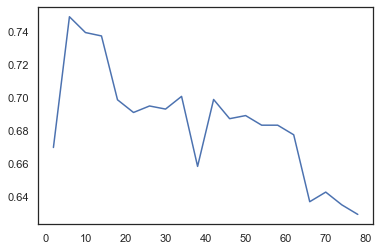

In [56]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

n_components = []
score = []

for i in np.arange(2,82,4):

    # pls model
    plsR = PLSRegression(n_components=i, scale=False).fit(x_train, y_train)

    # use plsR for LDAA
    lda = LinearDiscriminantAnalysis().fit(plsR.x_scores_, y_train)

    n_components.append(i)
    score.append(metrics.balanced_accuracy_score(y_test, lda.predict(plsR.transform(x_test))))

plt.plot(n_components, score)

print('no. of components for best score: {}'.format(n_components[score.index(max(score))]))

              precision    recall  f1-score   support

           0       0.80      0.74      0.77        86
           1       0.69      0.75      0.72        65

    accuracy                           0.75       151
   macro avg       0.75      0.75      0.75       151
weighted avg       0.75      0.75      0.75       151



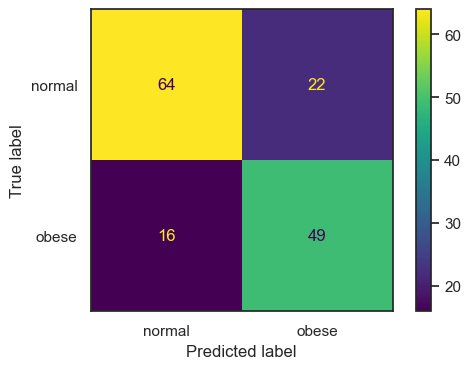

In [92]:
plsR = PLSRegression(n_components=6, scale=False).fit(x_train, y_train)

lda = LinearDiscriminantAnalysis().fit(plsR.x_scores_, y_train)

model_performance(y_test, lda.predict(plsR.transform(x_test)))

# to look at the species with highest absolute loadings
#species_data.columns[np.argsort(np.absolute(plsR.x_loadings_[:, 0]))[:10]]

The performance of the linear models were decent and the PLS-DA edged out the others veryyy slightly, but it's nothing to write home about.

### Kernel SVM ###

              precision    recall  f1-score   support

           0       0.75      0.79      0.77        86
           1       0.70      0.65      0.67        65

    accuracy                           0.73       151
   macro avg       0.72      0.72      0.72       151
weighted avg       0.73      0.73      0.73       151



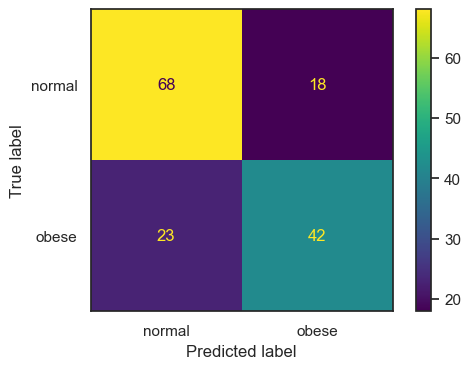

In [88]:
#step by step optimization

from sklearn.svm import SVC

svm_params = {'kernel':['rbf','sigmoid','poly'], 'C':uniform(loc=0, scale=10)}

svm = SVC(max_iter = 5000, random_state=78)

svm_cv = RandomizedSearchCV(svm, svm_params, scoring = 'balanced_accuracy', n_jobs = 8, refit=True).fit(x_train, y_train)

svm_cv.best_params_

model_performance(y_test, svm_cv.predict(x_test))

### Random Forest ###

I had tried decision trees as well, but didn't get good performance so it wasn't included.

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        86
           1       0.84      0.78      0.81        65

    accuracy                           0.84       151
   macro avg       0.84      0.83      0.84       151
weighted avg       0.84      0.84      0.84       151



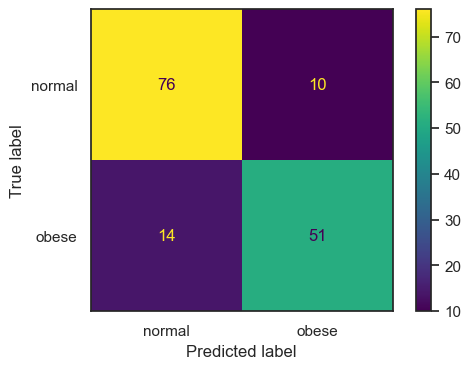

In [74]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=78)

forest_params = {'n_estimators':randint(0, 50), 'max_features':['sqrt','log2']}

forest_cv = RandomizedSearchCV(forest, forest_params, scoring = 'balanced_accuracy', n_jobs=8, refit=True).fit(x_train, y_train)

forest_cv.best_params_

model_performance(y_test, forest_cv.predict(x_test))

The random forest model is the best performing so far, which isn't surprising, since an ensemble model like this one does have more flexibility to fit to the data better. Next let's look at boosting

### Adaboost ###

              precision    recall  f1-score   support

           0       0.83      0.80      0.82        86
           1       0.75      0.78      0.77        65

    accuracy                           0.79       151
   macro avg       0.79      0.79      0.79       151
weighted avg       0.80      0.79      0.80       151



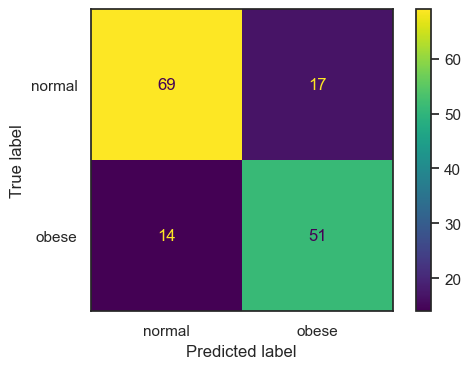

In [96]:
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import randint

ada = AdaBoostClassifier(random_state=78)

ada_params = {'n_estimators':randint(0, 200)}

ada_cv = RandomizedSearchCV(ada, ada_params, scoring = 'balanced_accuracy', n_jobs=8, refit=True).fit(x_train, y_train)

model_performance(y_test, ada_cv.predict(x_test))

### Gradient Boost ###

              precision    recall  f1-score   support

           0       0.87      0.90      0.88        86
           1       0.85      0.82      0.83        65

    accuracy                           0.86       151
   macro avg       0.86      0.86      0.86       151
weighted avg       0.86      0.86      0.86       151



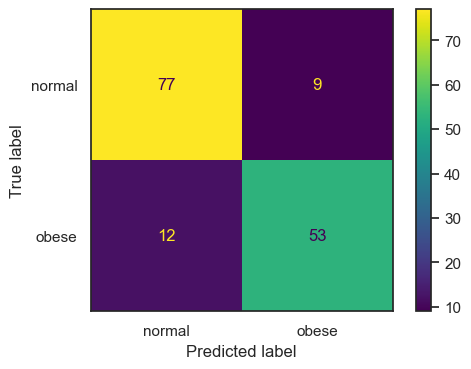

In [98]:
from sklearn.ensemble import GradientBoostingClassifier

grad = GradientBoostingClassifier(random_state=78)

grad_params = {'n_estimators':randint(0, 300)}

grad_cv = RandomizedSearchCV(grad, grad_params, n_jobs=8, refit=True).fit(x_train, y_train)

grad_cv.best_params_

model_performance(y_test, grad_cv.predict(x_test))

It seems like the Adaboost and Gradient boost models have the best performance and are quite comparable. Now let's take a look at metrics of the models.

In [110]:
models = [log_reg_CV, lda, svm_cv, forest_cv, ada_cv, grad_cv]

names = ['log regression', 'PLS-DA','kernel SVM', 'Random Forest', "Adaboost",'Gradient Boost']

model_comparison(models, names, x_test, y_test, plsR)


,Balanced Accuracy,ROC AUC,Precision 1,Precision 0,Recall 1,Recall 0
log regression,0.737,0.737,0.671,0.795,0.754,0.721
PLS-DA,0.749,0.749,0.690,0.800,0.754,0.744
kernel SVM,0.718,0.718,0.700,0.747,0.646,0.791
Random Forest,0.834,0.834,0.836,0.844,0.785,0.884
Adaboost,0.793,0.793,0.750,0.831,0.785,0.802
Gradient Boost,0.855,0.855,0.855,0.865,0.815,0.895


Let's take a look at the ROC and precision-recall plots as well. I'll only plot the 3 best performing models in this case, no point complicating the graphs needlessly.

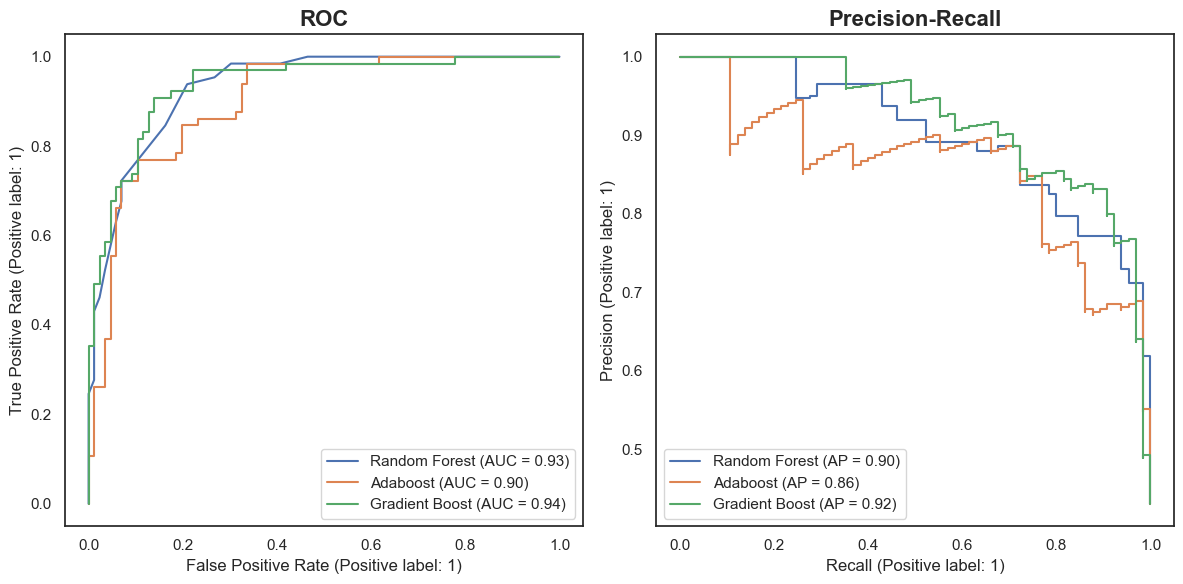

In [129]:
models = [forest_cv, ada_cv, grad_cv]

names = ['Random Forest', "Adaboost",'Gradient Boost']

fig, ax = plt.subplots(1,2, figsize=(12,6), dpi=100)

for i in range(len(names)):

    metrics.plot_roc_curve(models[i], x_test_, y_test, ax=ax[0], name = names[i])
    ax[0].set_title('ROC', fontsize=16,fontweight='demibold')
    # ax[0].tick_params(axis='both', labelsize=14)
    
    metrics.plot_precision_recall_curve(models[i], x_test_, y_test, ax=ax[1], name = names[i])
    ax[1].set_title('Precision-Recall', fontsize=16,fontweight='demibold')
    # ax[1].tick_params(axis='both', labelsize=14)

plt.tight_layout()

Seems like Gradient boost gives me the best accuracy and there's even a built in [feature importance](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_) measure! But impurity-based feature importance can be misleading, so I'll stick to permutation importance. This would be a good point to also mention that while permutation importance is useful for identifying important features, there are some things to take note of.

1. The calculated permutation importance is literally for that model *only*, meaning that if I were to retrain the model with a different split of the data or even a different random state, the values can come out different. So I'll use a loop to repeat the split-train/optimise-test process with the Gradient boost model and average the importance. 

    This approach does introduce another question: With a different split of the data, would another model performs better? It is quite possible but the ensemble methods will probably still come out on top and have fairly similar performance to each other. So I'm just going to use gradient boost.


2. Also, if two features are correlated, then the overall importance will be lowered since its split between the two.

A good [read](https://christophm.github.io/interpretable-ml-book/feature-importance.html) about permutation importance.

In [205]:
# loop to repeat the split-train-permutation impt process 30 times. 

# yes, I know there's probably a more efficient way to do this using pipeline and kfold or something, but copy-pasting code is easier :)

from sklearn.inspection import permutation_importance

impt = np.zeros(826,)
accuracy = 0
for i in range(30):
    
    # split data and scale
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    scaler = StandardScaler().fit(x_train)

    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)

    # train 
    grad = GradientBoostingClassifier()
    
    grad_params = {'n_estimators':randint(0, 300)}
    
    grad_cv = RandomizedSearchCV(grad, grad_params, n_jobs=8, refit=True).fit(x_train, y_train)

    accuracy += metrics.balanced_accuracy_score(y_test, grad_cv.predict(x_test))

    perm_impt = permutation_importance(grad_cv, x_test, y_test, scoring='balanced_accuracy', n_repeats=10, n_jobs=8)

    impt += perm_impt.importances_mean

# average importance and accuracy

impt = impt/30

accuracy = accuracy/30

impt_idx = impt.argsort()[::-1]

print('Top 10 species by feature importance:')

pd.DataFrame(data = impt[impt_idx[:10]], index =species_data.columns[impt_idx[:10]], columns=['Avg. perm. impt.'])


Top 10 species by feature importance:


,Avg. perm. impt.
Aeromonas unclassified,0.016614
Bacteroides coprophilus,0.009255
Bacteroides coprocola,0.008290
Butyrivibrio crossotus,0.005652
Veillonella parvula,0.005613
Clostridium perfringens,0.005267
Bacteroidales bacterium ph8,0.005064
Bacteroides intestinalis,0.004791
Eggerthella lenta,0.004379
Flavonifractor plautii,0.004357


Interestingly, there isn't a lot of overlap in the species with high permutation importance and those that were picked using the Mann-Whitney test. The same is for genera, as we can see that the genus of the bacteria above doesn't appear in the plots above. 

Now let's look at the distribution of these species important to the prediction. Since the abundance for any one species can be pretty sparse and spread over a wide range, I'll have to use a log-scale but the sparsity of the data will cause issues so I'll add 0.0001 to the data before plotting as a fix.

In [322]:
impt_species = ['Aeromonas unclassified', 'Bacteroides coprophilus',
       'Bacteroides coprocola', 'Butyrivibrio crossotus',
       'Veillonella parvula', 'Clostridium perfringens',
       'Bacteroidales bacterium ph8', 'Bacteroides intestinalis',
       'Eggerthella lenta', 'Flavonifractor plautii']

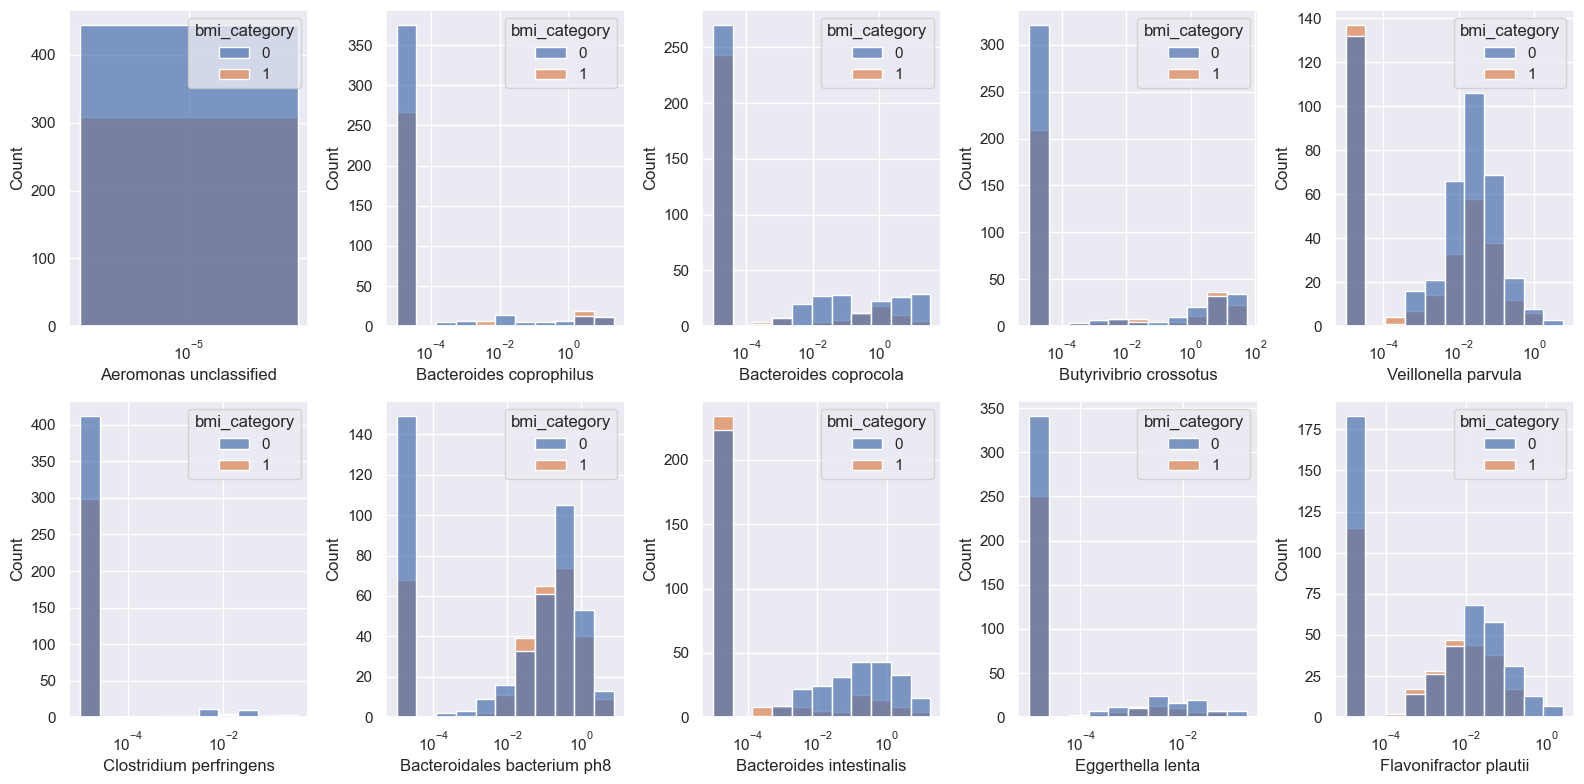

In [354]:
impt_subset = species_data[impt_species] + 0.00001

impt_subset = pd.concat([impt_subset, species_data['bmi_category']], axis=1)

fig = plt.figure(figsize=(16,8), dpi=100)

for i in range(10):
    fig.add_subplot(2, 5, i+1)
    sns.histplot(data=impt_subset, x = impt_species[i], hue='bmi_category', alpha=0.7, log_scale=10)
    # plt.xlim((0,100))
    # plt.xlabel(topSP[i])

# plt.suptitle('Relative abundance of species with significant differences between obese and normal populations', fontsize=16)
plt.tight_layout()

In [202]:
pd.DataFrame(data = impt[impt_idx[:10]], index =species_data.columns[impt_idx[:10]], columns=['Avg. perm. impt.'])

,Avg. perm. impt.
Aeromonas unclassified,0.016614
Bacteroides coprophilus,0.009255
Bacteroides coprocola,0.008290
Butyrivibrio crossotus,0.005652
Veillonella parvula,0.005613
Clostridium perfringens,0.005267
Bacteroidales bacterium ph8,0.005064
Bacteroides intestinalis,0.004791
Eggerthella lenta,0.004379
Flavonifractor plautii,0.004357


In [197]:
impt[567]

0.0

In [59]:
# perm_impt = pd.DataFrame(columns = ['Features', 'Forest','Grad', 'Ada', 'SVM'])

# perm_impt['Features'] = features

# perm_impt['Forest'] = forest_importance['importances_mean']

# perm_impt['Ada'] = ada_importance['importances_mean']

# perm_impt['Grad'] = grad_importance['importances_mean']

# perm_impt['SVM'] = svm_importance['importances_mean']

#perm_impt.to_csv('permutation_importance.csv', index=False)

In [60]:
# perm_impt = pd.read_csv('feature_importance.csv')

# forest_impt = list(perm_impt['Features'][perm_impt['Forest'] > 0])

# ada_impt = list(perm_impt['Features'][perm_impt['Ada'] > 0])

# grad_impt = list(perm_impt['Features'][perm_impt['Grad'] > 0])


In [31]:
# feature_count = []

# for model in ['Forest','Grad', 'Ada']:
#     feature_count.append((perm_impt[model] > 0).value_counts()[True])


In [63]:
# from matplotlib_venn import venn2

# forest_impt = list(perm_impt['Features'][perm_impt['Forest'] > 0])
# grad_impt = list(perm_impt['Features'][perm_impt['Grad'] > 0])
# ada_impt = list(perm_impt['Features'][perm_impt['Ada'] > 0])
# svm_impt = list(perm_impt['Features'][perm_impt['SVM'] > 0])


In [ ]:
# x_labels = ['Random Forest','Gradient Boost', 'AdaBoost']

# # Plot the figure.
# fig, ax = plt.subplots(1,1, figsize = (14,10), facecolor = 'white')

# ax = pd.Series(feature_count).plot(kind='bar')
# ax.set_title('No. of Important Features', fontsize = 18, fontweight = 'bold', pad = 10)
# ax.set_xlabel('Classifier', fontsize = 16, fontweight = 'bold', labelpad = 10)
# ax.set_ylabel('Count',  fontsize = 16, fontweight = 'bold', labelpad = 10)
# ax.set_xticklabels(x_labels, rotation = 0, fontsize = 14)

# rects = ax.patches

# # Make some labels.

# for rect, label in zip(rects, feature_count):
#     height = rect.get_height()
#     ax.text(rect.get_x() + rect.get_width() / 2, height + 1, label,
#             ha='center', va='bottom', fontsize = 14)

# plt.savefig('impt_feature_count.png', dpi=150)
    
# plt.show()


In [163]:
diabetes_impt = pd.read_csv('dict_diabetes.csv', names=['features', 'count'])

grad_impt = pd.read_csv('dict_obs.csv', names=['features', 'count'])

cirr_impt = pd.read_csv('dict_cirrhosis.csv', names=['features', 'count'])

In [ ]:
from venn import venn

test = {'Obesity':set(grad_impt['features']), 'Diabetes':set(diabetes_impt['features'])} #, 'Cirrhosis':set(cirr_impt['features'])}

fig, ax = plt.subplots(1,1, figsize = (14,10), facecolor='white')

venn(test, fontsize = 18, legend_loc = 'lower left', ax=ax)

#ax.set_title('Feature Overlap between Classifiers', fontsize = 18, fontweight ='bold', y=0.90)

plt.tight_layout()

plt.savefig('venn_diagram.png', dpi=200)



In [54]:
del test

### Gradient Boost analysis ###

In [6]:

#grad_perm.to_csv('grad_perm_impt.csv', index=False)

grad_perm = pd.read_csv('obs_avg_impt.csv')

In [ ]:
from sklearn.inspection import permutation_importance

from sklearn.ensemble import GradientBoostingClassifier

impt_score = np.zeros((826,))

for i in range(50):
    # split data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

    grad = GradientBoostingClassifier(n_estimators = 145, max_depth = 5).fit(x_train, y_train)
    
    perm_impt = permutation_importance(grad, x_test, y_test, scoring='balanced_accuracy', n_jobs = 2)
    
    # filter dataset
    
    impt_score += perm_impt['importances_mean']
    
temp1 = pd.DataFrame(columns = ['features','impt'])
    
temp1['features'] = short
temp1['impt'] = impt_score/50
    
temp2 = temp1[temp1['impt'] > 0].copy()
temp2.sort_values(by='impt', ascending=False, inplace=True, ignore_index=True)

In [113]:
temp2[:10]

,features,impt
0,Klebsiella pneumoniae,0.022613
1,Bacteroides intestinalis,0.010920
2,Bacteroides stercoris,0.005639
3,Bacteroides pectinophilus,0.003882
4,Streptococcus thermophilus,0.003866
5,Ruminococcus obeum,0.003856
6,Bacteroides massiliensis,0.003327
7,Sutterella wadsworthensis,0.003230
8,Prevotella copri,0.002498
9,Barnesiella intestinihominis,0.002216


In [115]:
temp2.to_csv('obs_avg_impt.csv', index_label=None)

In [150]:
# dataframe of impt bacteria and permutation importance

# grad_perm = pd.DataFrame(columns = ['Features','importances_mean', 'importances_std'])
# grad_perm['Features'] = species
# grad_perm['importances_mean'] = grad_importance['importances_mean']
# grad_perm['importances_std'] = grad_importance['importances_std']
# grad_perm = grad_perm[grad_perm['importances_mean'] > 0].copy()
# grad_perm.sort_values(by='importances_mean', ascending=False, inplace=True, ignore_index=True)

In [78]:
test = list(temp2[:11]['features'])

test.pop(8)

'Streptococcus australis'

In [80]:
# dataframe with all data including BMI, country etc

stuff = list(processed.columns[:7]) + test + ['label']

grad_stuff = processed[stuff]

In [82]:
# changing labels for control and obese

#grad_stuff = grad_means.copy()

grad_stuff['label'][grad_stuff['label'] == 1] = 'Obese'

grad_stuff['label'][grad_stuff['label'] == 0] = 'Ctrl'

In [89]:
# calculate mean species abundance for each species

means = grad_stuff.groupby(by = 'label').mean().iloc[:,1:]

# create a dataframe for mean abundance

grad_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

grad_means['Bacteria'] = test
grad_means['Ctrl'] = list(means.iloc[0, :10])
grad_means['Obese'] = list(means.iloc[1, :10])

In [123]:
mann = []

for i in test:
    ctrl = grad_stuff[i][grad_stuff['label'] == 'Ctrl']
    fat = grad_stuff[i][grad_stuff['label'] == 'Obese']
    mann.append(sp.stats.mannwhitneyu(ctrl, fat))

In [133]:
mann

[MannwhitneyuResult(statistic=50021.0, pvalue=5.743462986209846e-29),
 MannwhitneyuResult(statistic=56065.0, pvalue=1.0373227210850577e-13),
 MannwhitneyuResult(statistic=53000.5, pvalue=4.4726913092891246e-14),
 MannwhitneyuResult(statistic=54095.0, pvalue=1.7819259764379774e-13),
 MannwhitneyuResult(statistic=74871.0, pvalue=0.0913742088911158),
 MannwhitneyuResult(statistic=56985.0, pvalue=3.5359461021296864e-11),
 MannwhitneyuResult(statistic=76291.5, pvalue=0.3969552609320985),
 MannwhitneyuResult(statistic=54231.0, pvalue=4.563468300691354e-13),
 MannwhitneyuResult(statistic=76269.0, pvalue=0.40894672831154855),
 MannwhitneyuResult(statistic=72018.0, pvalue=0.06459181295598002)]

In [ ]:
ind = np.arange(len(grad_means))

width = 0.4

fig, ax = plt.subplots(figsize = (16,10))

color = ['royalblue', 'orange']
ax.barh(ind, grad_means.Ctrl, width, color = color[1], label = 'Ctrl', edgecolor ='black')
ax.barh(ind + width, grad_means.Obese, width, color = color[0], label = 'Obese', edgecolor ='black')
ax.set(yticks = ind + width/2, yticklabels = grad_means.Bacteria)
#ax.set_title('Mea', fontsize = 18, fontweight='bold', pad=20)
#ax.set_xscale('log')
ax.set_ylabel('Species', fontsize = 18, fontweight='bold')
ax.set_xlabel("Relative Abundance", fontsize = 18, fontweight = 'bold', labelpad = 20)
ax.legend(loc='lower right', fontsize = 'x-large')
ax.tick_params(axis='both', labelsize = 14)
plt.gca().invert_yaxis()

plt.savefig('Grad_impt_abundance.png', dpi=200, bbox_inches = "tight")

plt.show()

In [ ]:
plt.figure(figsize=(12,8))

plt.plot(temp2['impt'])

plt.xlabel('Species', fontsize = 16, fontweight = 'bold', labelpad=10)
plt.tick_params(axis='both', labelsize=10)

plt.ylabel('Permutation Importance', fontsize = 16, fontweight = 'bold', labelpad=10)

plt.tight_layout()

plt.savefig('grad_perm_impt_line.png', dpi=200)

In [93]:
test

['Klebsiella pneumoniae',
 'Bacteroides intestinalis',
 'Dorea longicatena',
 'Bacteroides stercoris',
 'Bacteroides pectinophilus',
 'Bacteroides massiliensis',
 'Clostridium sp L2 50',
 'Barnesiella intestinihominis',
 'Streptococcus thermophilus',
 'Ruminococcus obeum']

grad_perm = perm_impt[['Features','Grad']].copy()

grad_perm = grad_perm[grad_perm['Grad'] > 0].copy()

# sort from highest to lowest importance
grad_perm.sort_values(by='Grad', ascending=False, inplace=True, ignore_index=True)

impt_features = grad_perm['Features'].copy()


regex to shorten species names

c = re.compile(r's__(\w+)')

short = []

for i in grad_perm['Features']:
    short.append( c.search(i).group(1).replace("_", " "))
    
grad_perm['Features'] = short


create a list of features we want from the original data
stuff = list(processed.columns[:7]) + list(impt_features) + ['label']

# filter the original dataset

grad_stuff = processed[stuff].copy()

# change bacteria name to be shorter
new = dict(zip(impt_features, short))

grad_stuff.rename(columns = new, inplace=True)

# changing labels for control and obese
grad_stuff['label'][grad_stuff['label'] == 1] = 'Obese'

grad_stuff['label'][grad_stuff['label'] == 0] = 'Ctrl'

# calculate mean species abundance for each species

means = grad_stuff.groupby(by = 'label').mean().iloc[:,1:]

# create a dataframe for mean abundance

grad_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

grad_means['Bacteria'] = short
grad_means['Ctrl'] = list(means.iloc[0, :])
grad_means['Obese'] = list(means.iloc[1, :])

# plots permutation importance and abundance

fig, ax = plt.subplots(1,2, figsize=(16,10))


ax[0].plot(grad_perm['Grad'])
ax[0].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[0].set_ylabel('Permutation importance', fontsize=18, labelpad = 10)
ax[0].tick_params(axis="both", labelsize=14)

ax[1].scatter([range(len(grad_perm))], grad_means['Ctrl'])
ax[1].scatter([range(len(grad_perm))], grad_means['Obese'])
ax[1].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[1].set_ylabel('Species Abundance', fontsize=18, labelpad = 5)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].legend(['Control','Obese'], fontsize = 'xx-large')

plt.tight_layout()
plt.savefig('grad_perm_importance.png', dpi=150)
plt.show()


### Comparison plots for the 11 common ones ###

In [66]:
# this one basically finds the common species in all models
common = [i for i in species if (i in forest_impt) and (i in grad_impt) and (i in ada_impt)]

# this one is to remove the s__ in the species names
c = re.compile(r's__(\w+)')

short = []

for i in common:
    short.append( c.search(i).group(1).replace("_", " "))

In [68]:
# filers the feature importance table to see the 8 common species got what coefficient

common_impt = perm_impt[perm_impt['Features'].isin(common)]

In [69]:
# create a new table from the original table that consists of the 8 common bacteria and the other info

common_only = processed[(list(processed.columns[:7]) + common + ['label'])]

common_only['label'][common_only['label'] == 1] = 'Obese'

common_only['label'][common_only['label'] == 0] = 'Ctrl'

# rename the columns to the shortened bacteria name 
common_only.rename(columns = dict(zip(common_only.columns[7:-1], short)), inplace =True)


# create 2 dataframes with mean and std dev for each species and BMI

means = common_only.groupby(by = 'label').mean().iloc[:,1:]
error = common_only.groupby(by = 'label').std().iloc[:,1:]

In [70]:
#  creates a dataframe with species name, then the mean species abundance for controls and obese groups then plot a barchart

compare_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

compare_means['Bacteria'] = short
compare_means['Ctrl'] = list(means.iloc[0, :])
compare_means['Obese'] = list(means.iloc[1, :])

# compare_means.plot(x = 'Bacteria', y = ['Ctrl', 'Obese'], kind='barh', title = 'All', logx=True, figsize = (14,8), 
#                    xlabel = 'Mean Relative Abundance', ylabel = 'Bacteria', fontsize=14)

In [ ]:
create_summary(common_only, list(common_only['country']))

In [ ]:
create_summary(common_only, ['china'], name= "China", filename = 'china_8_common.png')

In [74]:
# this functions calculates the mean of the relative abundance and plots barcharts. 
# Take note that it uses some variables that were declared earlier, so it is not entirely standalone. No need to remove the categorical stuff
# since groupby removes them

def create_summary(dataframe, group, name = 'Unnamed', filename = ('Unnamed' + '.png'), color = ['royalblue', 'orange']):

    #create new DF with the group of interest
    grouped = dataframe[dataframe['country'].isin(group)].copy()
    
    # create 2 dataframes with mean and std dev for each species and BMI

    g_means = grouped.groupby(by = 'label').mean().iloc[:,1:]
    g_error = grouped.groupby(by = 'label').std().iloc[:,1:]

    #  creates a dataframe with species name, then the mean species abundance for controls and obese groups then plot a barchart

    grouped_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

    grouped_means['Bacteria'] = short
    grouped_means['Ctrl'] = list(g_means.iloc[0, :])
    grouped_means['Obese'] = list(g_means.iloc[1, :])

    ind = np.arange(len(grouped_means))

    width = 0.4

    fig, ax = plt.subplots(figsize = (16,10))


    ax.barh(ind, grouped_means.Obese, width, color = color[0], label = 'Obese')
    ax.barh(ind + width, grouped_means.Ctrl, width, color = color[1], label = 'Ctrl')
    ax.set(yticks = ind + width, yticklabels = grouped_means.Bacteria)
    ax.set_title(name, fontsize = 18, fontweight='bold', pad=20)
    ax.set_xscale('log')
    ax.set_ylabel('Species', fontsize = 18, fontweight='bold')
    ax.set_xlabel("Log Relative Abundance", fontsize = 18, fontweight = 'bold', labelpad = 20)
    ax.legend(loc='lower right', fontsize = 'x-large')
    ax.tick_params(axis='both', labelsize = 14)
    plt.gca().invert_yaxis()
    
    #plt.savefig(filename, dpi=150, bbox_inches = "tight")
    
    plt.show()

In [ ]:
create_summary(common_only, ['china'], name= "China", filename = 'china_8_common.png')

### Random Forest feature analysis ### 

In [98]:
test = processed.iloc[:, 7:-1].corr()

In [107]:
test.fillna(0, inplace=True)

In [ ]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(test, xticklabels=False, yticklabels =False, cmap = cmap)

In [ ]:
data['dataset_name'].value_counts()

In [44]:
# create dataframe that contains all impt features from random forest model and sort them

forest_perm = perm_impt[['Features','Forest']].copy()

forest_perm = forest_perm[forest_perm['Forest'] > 0].copy()

forest_perm.sort_values(by='Forest', ascending=False, inplace=True, ignore_index=True)

impt_features = forest_perm['Features'].copy()


# regex to shorten species names

c = re.compile(r's__(\w+)')

short = []

for i in forest_perm['Features']:
    short.append( c.search(i).group(1).replace("_", " "))

forest_perm['Features'] = short

# create a list of features we want from the original data
stuff = list(processed.columns[:7]) + list(impt_features) + ['label']

# filter the original dataset

forest_stuff = processed[stuff].copy()

# change bacteria name to be shorter
new = dict(zip(impt_features, short))

forest_stuff.rename(columns = new, inplace=True)

# changing labels for control and obese
forest_stuff['label'][forest_stuff['label'] == 1] = 'Obese'

forest_stuff['label'][forest_stuff['label'] == 0] = 'Ctrl'


In [40]:
# calculate mean species abundance for each species

means = forest_stuff.groupby(by = 'label').mean().iloc[:,1:]

# create a dataframe for mean abundance

forest_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

forest_means['Bacteria'] = short
forest_means['Ctrl'] = list(means.iloc[0, :])
forest_means['Obese'] = list(means.iloc[1, :])



In [ ]:
# dual plot of perm importance and species abundance

fig, ax = plt.subplots(1,2, figsize=(16,10))


ax[0].plot(forest_perm['Forest'])
ax[0].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[0].set_ylabel('Permutation importance', fontsize=18, labelpad = 10)
ax[0].tick_params(axis="both", labelsize=14)

ax[1].scatter([range(35)], forest_means['Ctrl'])
ax[1].scatter([range(35)], forest_means['Obese'])
ax[1].set_xlabel('Species', fontsize=18, labelpad = 10)
ax[1].set_ylabel('Species Abundance', fontsize=18, labelpad = 5)
ax[1].tick_params(axis="both", labelsize=14)
ax[1].legend(['Control','Obese'], fontsize = 'xx-large')

plt.tight_layout()
plt.savefig('forest_perm_importance.png', dpi=150)
plt.show()


In [54]:
# plot barchart

create_summary(forest_stuff, list(forest_stuff['country'].unique()), name='forest')

eu = ['denmark', 'spain', 'sweden', 'germany','france', 'iceland']

# create_summary(forest_stuff, eu, name='forest')

In [55]:
# find the common and different points

# create dataframe of the EU and CN data and obtain their means
eu_only = forest_stuff[forest_stuff['country'].isin(eu)]

cn_only = forest_stuff[forest_stuff['country'].isin(['china'])]

eu_mean = eu_only.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

cn_mean = cn_only.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

eu_mean['ctrl_larger'] = eu_mean['Ctrl'] > eu_mean['Obese']

cn_mean['ctrl_larger'] = cn_mean['Ctrl'] > cn_mean['Obese']

# agreement dataframe

eu_mean['agreement'] = eu_mean['ctrl_larger'] & cn_mean['ctrl_larger']

agreed = eu_mean[['index','agreement']][eu_mean['agreement'] == True].copy()

In [57]:
# common and differences for the EU countries

den = forest_stuff[forest_stuff['country'].isin(['denmark'])]

#france = forest_stuff[forest_stuff['country'].isin(['france'])]

den_mean = den.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

#france_mean = france.groupby(by='label').mean().drop(columns = 'bmi').transpose().reset_index()

den_mean['ctrl_larger'] = den_mean['Ctrl'] > den_mean['Obese']

#france_mean['ctrl_larger'] = france_mean['Ctrl'] > france_mean['Obese']

# agreement dataframe

den_mean['agreement'] = den_mean['ctrl_larger'] & cn_mean['ctrl_larger']

#agreed = eu_mean[['index','agreement']][eu_mean['agreement'] == True].copy()

In [ ]:
#create new DF with the group of interest

# grouped = forest_stuff[ list(agreed['index']) + ['label'] ]

# create 2 dataframes with mean and std dev for each species and BMI

# g_means = grouped.groupby(by='label').mean().iloc[:,:]
# g_error = grouped.groupby(by= 'label').std().iloc[:,:]

#  creates a dataframe with species name, then the mean species abundance for controls and obese groups then plot a barchart

# grouped_means = pd.DataFrame(columns = ['Bacteria','Ctrl','Obese'])

# grouped_means['Bacteria'] = list(grouped.columns[:-1])
# grouped_means['Ctrl'] = list(g_means.iloc[0, :])
# grouped_means['Obese'] = list(g_means.iloc[1, :])

ind = np.arange(len(grouped_means))

width = 0.4

fig, ax = plt.subplots(figsize = (16,10))

color = ['royalblue', 'orange']
ax.barh(ind, grouped_means.Obese, width, color = color[0], label = 'Obese')
ax.barh(ind + width, grouped_means.Ctrl, width, color = color[1], label = 'Ctrl')
ax.set(yticks = ind + width, yticklabels = grouped_means.Bacteria)
ax.set_title('test', fontsize = 18, fontweight='bold', pad=20)
ax.set_xscale('log')
ax.set_ylabel('Species', fontsize = 18, fontweight='bold')
ax.set_xlabel("Log Relative Abundance", fontsize = 18, fontweight = 'bold', labelpad = 20)
ax.legend(loc='lower right', fontsize = 'x-large')
ax.tick_params(axis='both', labelsize = 14)
plt.gca().invert_yaxis()

# #plt.savefig(filename, dpi=150, bbox_inches = "tight")

plt.show()

In [ ]:
eu_mean['label'][eu_mean['agreement']==True]

In [78]:
# let's try comparing importance with abundance

forest_perm['relative_impt'] = forest_perm['Forest'].div(forest_perm['Forest'].sum(), axis=0)